In [1]:
# Load results from experiments

import pickle 
import os 
import jax 
import re
import numpy as np
from pathlib import Path
from collections import defaultdict as dd
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
results_folder = "/scr/aliang80/changepoint_aug/changepoint_aug/density_estimation/ray_results"

def get_exp_df(exp_name_map):
    # group results based on seed 
    results = {}

    # search exps under the folder
    exp_names = list(exp_name_map.keys())
    for exp_name in exp_names:
        exp_folder = Path(results_folder) / exp_name
        exp_folders = list(exp_folder.glob("*"))

        exp_results = dd(list)

        for folder in exp_folders:
            if not folder.is_dir():
                continue
            
            base_name = folder.name
            
            # remove seed from name
            base = re.sub(r'_s-\d', '', base_name)

            # look at the ckpt files to see the best result 
            ckpt_folder = folder / "model_ckpts"
            
            # print(ckpt_folder)
            if not ckpt_folder.exists():
                print(f"No ckpt folder for {ckpt_folder}")
                continue

            best_f = ckpt_folder / "best.txt"
            if not best_f.exists():
                continue

            with open(best_f, 'r') as f:
                epoch, sr = f.read().split(",")
                sr = sr.strip()

            # # remove the exp name from the base name
            # # get number of trajectories
            # num_trajs = re.search(r'nt-\d+', base).group(0).split("-")[1]
            # base = int(num_trajs)
            
            base = base.replace(exp_name + "_", "")
            exp_results[base].append(float(sr))

        results[exp_name_map[exp_name]] = exp_results

    # convert to dataframe
    df = pd.DataFrame.from_dict(results, orient='index')

    # sort dataframe by name 
    def sort_by_nt(x):
        return int(re.search(r'nt-\d+', x).group(0).split("-")[1])
    df = df.reindex(sorted(df.columns, key=sort_by_nt), axis=1).transpose()

    print(df)
    # take the mean of each cell in df
    df_mean = df.map(lambda x: np.mean(x))
    df_std = df.map(lambda x: np.std(x))
    return df_mean, df_std

In [9]:
exp_name_map = {
    "i022_bc_base": "BC",
    "i023_bc_pvar_500": "BC Aug (PVar 500)",
    "i023_bc_pvar_1000": "BC Aug (PVar 1000)",
    "i022_bc_base_gaussian": "BC w/ Gaussian",
    "i024_bc_if_500": "BC Aug (IF 500)",
    "i024_bc_if_1000": "BC Aug (IF 1000)",
}

df_mean, df_std = get_exp_df(exp_name_map)

                                         BC               BC Aug (PVar 500)  \
nt-5     [0.32, 0.3, 0.2, 0.26, 0.24, 0.08]   [0.32, 0.28, 0.36, 0.26, 0.4]   
nt-10         [0.38, 0.4, 0.24, 0.36, 0.26]   [0.22, 0.36, 0.26, 0.32, 0.2]   
nt-25   [0.3, 0.34, 0.48, 0.36, 0.44, 0.36]   [0.48, 0.36, 0.4, 0.38, 0.44]   
nt-50   [0.42, 0.48, 0.42, 0.5, 0.48, 0.42]    [0.56, 0.52, 0.5, 0.3, 0.36]   
nt-75   [0.54, 0.46, 0.42, 0.6, 0.36, 0.54]  [0.54, 0.46, 0.52, 0.52, 0.44]   
nt-100  [0.4, 0.54, 0.56, 0.48, 0.48, 0.68]                             NaN   

                    BC Aug (PVar 1000)                  BC w/ Gaussian  \
nt-5     [0.42, 0.32, 0.4, 0.34, 0.36]  [0.24, 0.14, 0.22, 0.16, 0.24]   
nt-10    [0.44, 0.3, 0.36, 0.42, 0.32]  [0.32, 0.38, 0.28, 0.32, 0.42]   
nt-25    [0.58, 0.4, 0.42, 0.46, 0.48]  [0.36, 0.32, 0.26, 0.28, 0.36]   
nt-50     [0.6, 0.42, 0.58, 0.46, 0.4]   [0.44, 0.44, 0.4, 0.32, 0.36]   
nt-75   [0.48, 0.56, 0.52, 0.48, 0.56]   [0.4, 0.44, 0.56, 0.54, 0.44]   
nt

In [10]:
df_mean

,BC,BC Aug (PVar 500),BC Aug (PVar 1000),BC w/ Gaussian,BC Aug (IF 500),BC Aug (IF 1000)
nt-5,0.233333,0.324,0.368,0.200,0.248,0.280
nt-10,0.328000,0.272,0.368,0.344,0.292,0.300
nt-25,0.380000,0.412,0.468,0.316,0.304,0.336
nt-50,0.453333,0.448,0.492,0.392,0.420,0.440
nt-75,0.486667,0.496,0.520,0.476,0.460,0.476
nt-100,0.523333,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Success Rate (%)')

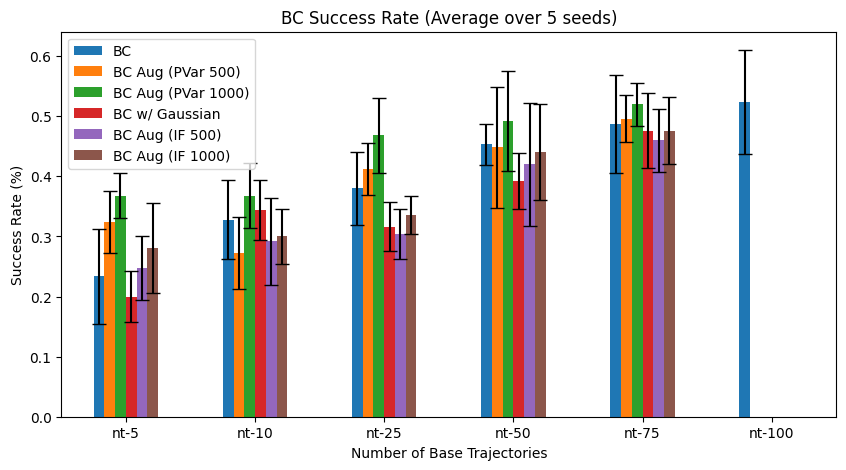

In [12]:
ax = df_mean.plot(yerr=df_std, kind="bar", rot=0, capsize=5, figsize=(10, 5))
ax.set_title('BC Success Rate (Average over 5 seeds)')
ax.set_xlabel('Number of Base Trajectories')
ax.set_ylabel('Success Rate (%)')